In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Make sure mmc repository is in pythonpath
import sys
sys.path.append('/home/dallaert/tools/a2e-mmc/')

In [4]:
from mmctools.plotting import plot_timeheight, plot_timehistory_at_height, plot_profile, plot_spectrum
from mmctools.helper_functions import calc_wind, theta

In [5]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16

# Demonstrate plotting library

## Load data

Load a processed TTU dataset for demonstration purposes. The dataset can be obtained by running the notebook "process_TTU_tower.ipynb" which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment) (currently only in the dev branch)

In [6]:
datadir = './'
TTUdata = 'TTU_tilt_corrected_20131108-09.csv'

In [7]:
df = pd.read_csv(os.path.join(datadir,TTUdata),parse_dates=True,index_col=['datetime','height'])
df.head()

u         v         w          Ts        T      RH  \
datetime   height                                                              
2013-11-08 0.9    -0.138929  2.637817  0.074016  289.410000  284.794  26.186   
           2.4    -0.601111  2.783204  0.487330  290.979994  284.932  25.810   
           4.0     0.416792  4.043940  0.295800  287.520000  285.166  25.380   
           10.1   -0.276479  5.227110 -0.418065  287.250000  285.298  25.264   
           16.8    0.034364  5.908367 -0.173836  287.610000  285.414  24.934   

                            p  
datetime   height              
2013-11-08 0.9     908.547754  
           2.4     908.723508  
           4.0     908.215548  
           10.1    907.611414  
           16.8    907.307654

Do some additional data processing

In [8]:
# Calculate wind speed and direction
df['wspd'], df['wdir'] = calc_wind(df)
df['theta'] = theta(df['T'],df['p'])

In [9]:
# Calculate 10min averages
df10 = df.unstack().resample('10min').mean().stack()

## Default plotting tools

Pivoting Dataset


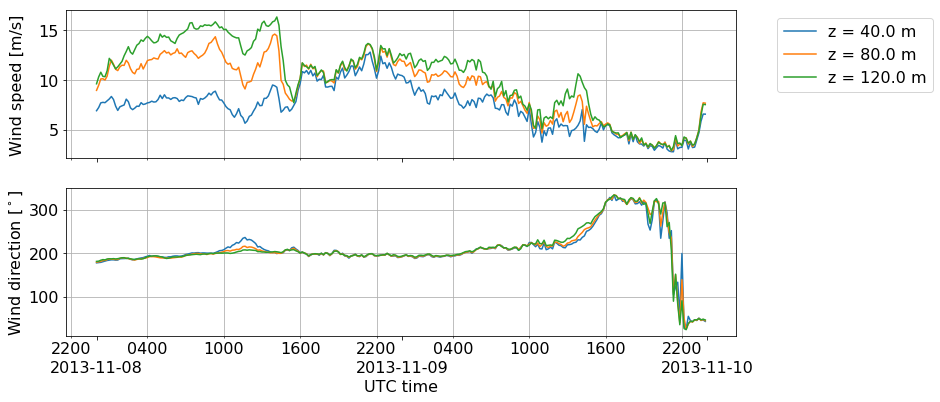

In [10]:
fig,ax = plot_timehistory_at_height(df10,
                                    fields = ['wspd','wdir'],
                                    heights = [40,80,120]
                                   )

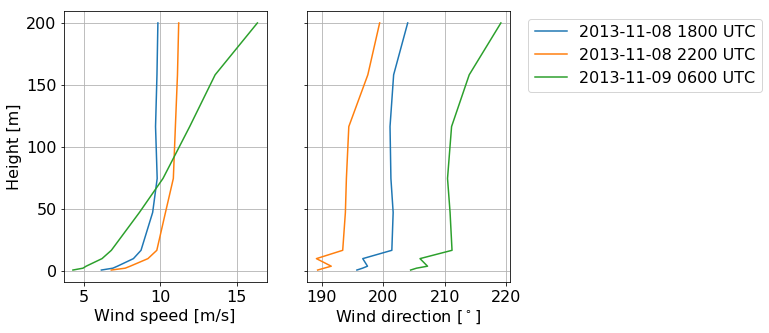

In [11]:
fig,ax = plot_profile(df10,
                      fields = ['wspd','wdir'],
                      times = ['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 6:00:00'],
                     )

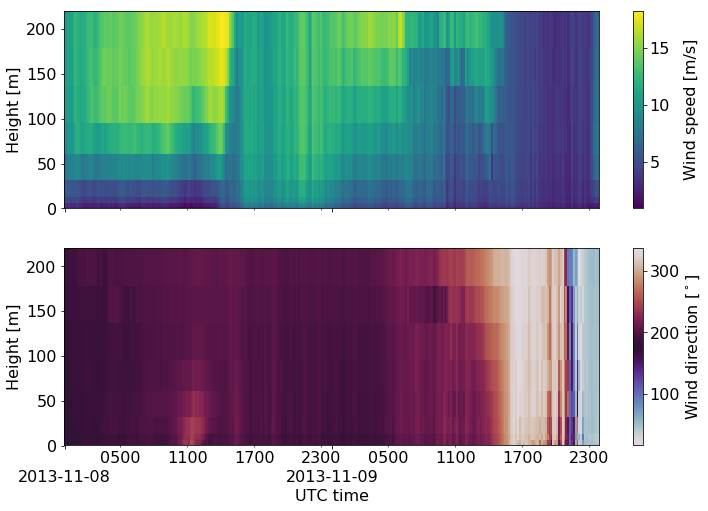

In [12]:
fig,ax,cbar = plot_timeheight(df10,fields = ['wspd','wdir'])

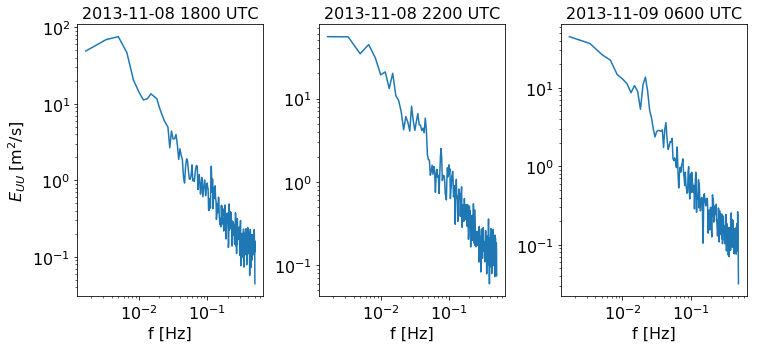

In [13]:
fig,ax = plot_spectrum(df,
                       height = 80,
                       fields = 'wspd',
                       times = ['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 6:00:00'],
                      )

## Advanced plotting examples

Plot timehistory at all TTU heights using a custom colormap

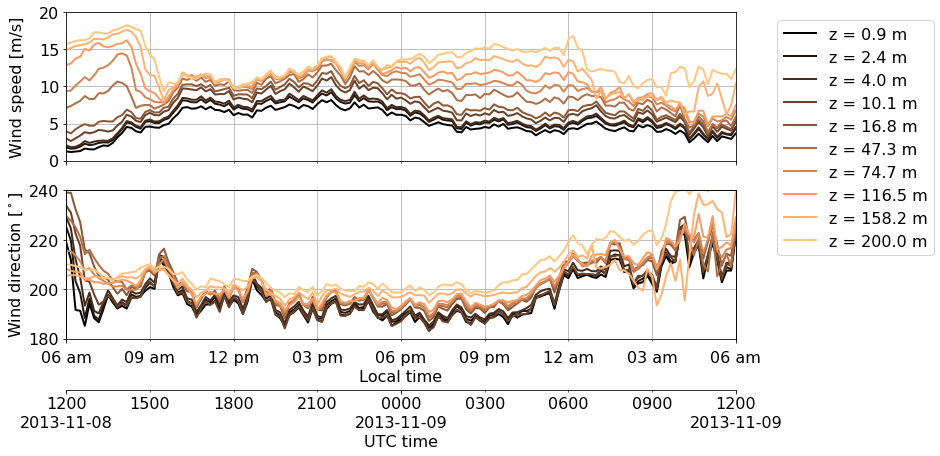

In [14]:
fig,ax,ax2 = plot_timehistory_at_height(df10, fields = ['wspd','wdir'], heights = 'all',
                                    # Specify field limits
                                    fieldlimits={'wspd':(0,20),'wdir':(180,240)},
                                    # Specify time limits
                                    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
                                    # Specify colormap
                                    cmap='copper',
                                    # Plot local time axis
                                    plot_local_time=True, local_time_offset=-6,
                                    # Additional keyword arguments to personalize plotting style
                                    linewidth=2,linestyle='-',marker=None,
                                   )

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)

# Adjust xaxis tick locations of UTC time axis
ax2.xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))

Compare instantaneous profiles with 10-min averaged profiles.

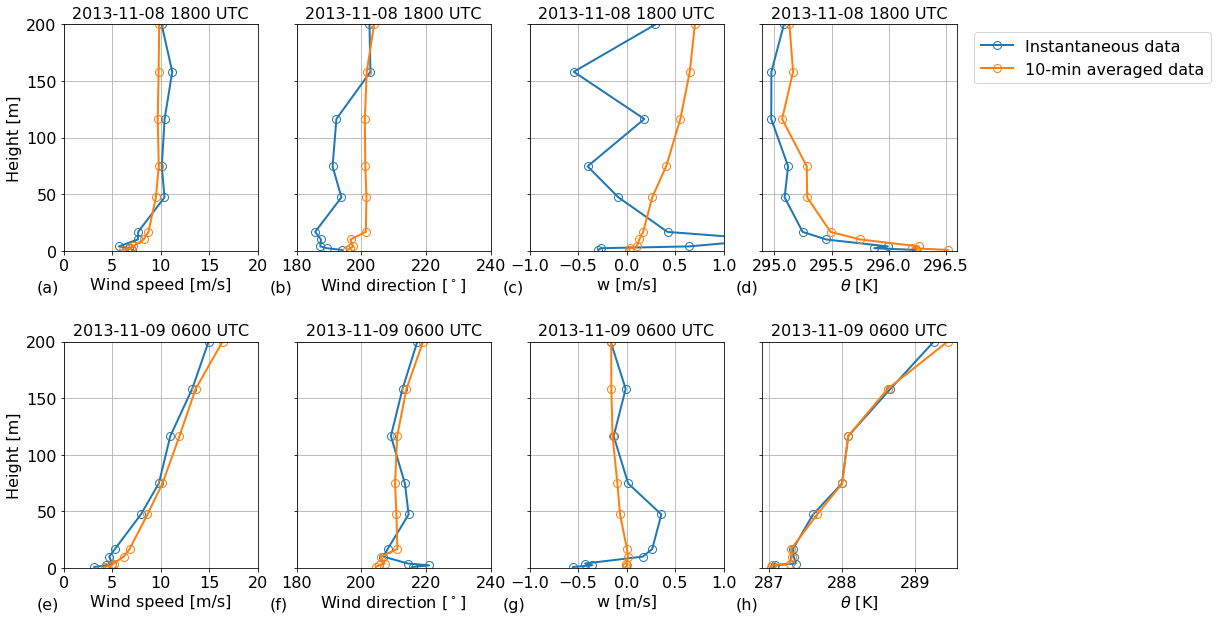

In [15]:
fig,ax = plot_profile(datasets={'Instantaneous data':df,'10-min averaged data':df10},
                      fields=['wspd','wdir','w','theta'],
                      times=['2013-11-08 18:00:00','2013-11-09 06:00:00'],
                      # Specify field limits
                      fieldlimits={'wspd':(0,20),'wdir':(180,240),'w':(-1,1)},
                      # Specify height limits
                      heightlimits=(0,200),
                      # Stack results by dataset instead of times
                      stack_by_datasets=True,
                      # Specify custom field labels
                      fieldlabels={'w':'w [m/s]'},
                      # Label subplots
                      labelsubplots=True,
                      # Change field order to have different fields correspond to different columns instead of rows
                      fieldorder='F',
                      # Additional keyword arguments to personalize plotting style
                      linewidth=2,marker='o',markersize=8,mfc="none",
                     )